## Imports

In [1]:
import tensorflow as tf

#Useful Stuff y'know
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as im
from PIL import Image as PILImage
import numpy as np
import pandas as pd

# File Management
import os
from xml.etree import ElementTree as ET

In [2]:
classNames = ['keyboard', 'mouse', 'monitor']
imageShrink = (64, 64)

## Import Images (to be changed to use XML)

In [3]:
imageList = []
imageDir = 'images/'

for file in os.listdir(imageDir):
    filename = os.fsdecode(file)
    if filename.endswith(".jpg"):
        image = im.imread(imageDir + file)
        #image = image / 255.0
        imageList.append(image)

In [4]:
imageList[0]

array([[[103, 113, 149],
        [ 92, 102, 137],
        [ 70,  80, 115],
        ...,
        [166, 160, 124],
        [169, 163, 127],
        [174, 168, 132]],

       [[104, 114, 150],
        [ 99, 109, 144],
        [ 85,  95, 130],
        ...,
        [166, 160, 124],
        [167, 161, 125],
        [172, 166, 130]],

       [[ 97, 107, 142],
        [105, 115, 150],
        [109, 119, 154],
        ...,
        [165, 159, 123],
        [166, 160, 124],
        [170, 164, 128]],

       ...,

       [[ 71,  77,  73],
        [ 73,  79,  75],
        [ 74,  80,  76],
        ...,
        [ 27,  28,  23],
        [ 30,  31,  26],
        [ 33,  34,  29]],

       [[ 72,  78,  74],
        [ 72,  78,  74],
        [ 73,  79,  75],
        ...,
        [ 28,  29,  24],
        [ 29,  30,  25],
        [ 30,  31,  26]],

       [[ 71,  77,  73],
        [ 70,  76,  72],
        [ 68,  74,  70],
        ...,
        [ 29,  30,  25],
        [ 29,  30,  25],
        [ 29,  30,  25]]

## Import Annotation XMLs

In [5]:
annotationsList = []
annotationsDir = 'annotations/xml/'

for file in os.listdir(annotationsDir):
    xml = ET.parse(annotationsDir + file)
    annotationsList.append(xml)

## Isolate selected objects in image for model training

In [6]:
maxObjs = 0
for annotation in annotationsList:
    for obj in annotation.iter('object'):
        maxObjs += 1
        
maxObjs

107

In [7]:
print(annotationsList[0].getroot()[6])

obj = annotationsList[0].getroot()[6]
xmin = int(obj[4][0].text)
ymin = int(obj[4][1].text)
xmax = int(obj[4][2].text)
ymax = int(obj[4][3].text)

image = PILImage.fromarray(imageList[0][ymin:ymax, xmin:xmax]).resize((64, 64), PILImage.BILINEAR)
pixels = list(image.getdata())
for i in range(len(pixels)):
    pixels[i] = list(pixels[i])
width, height = image.size
pixels = [pixels[i * width:(i + 1) * width] for i in range(height)]

<Element 'object' at 0x7f673a68f090>


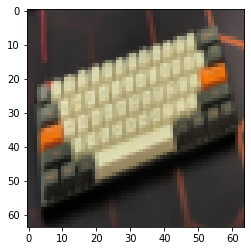

In [8]:
objectList = []
objectLabels = []
index = 0

for annotation in annotationsList:
    for obj in annotation.iter('object'):
        xmin = int(obj[4][0].text)
        ymin = int(obj[4][1].text)
        xmax = int(obj[4][2].text)
        ymax = int(obj[4][3].text)

        type = obj[0].text

        if type == 'keyboard':
            key = 0
        elif type == 'mouse':
            key = 1
        elif type == 'monitor':
            key = 2

            
        #Resize image to 64x64
        image = PILImage.fromarray(imageList[0][ymin:ymax, xmin:xmax]).resize((64, 64), PILImage.BILINEAR)
        pixels = list(image.getdata())
        for i in range(len(pixels)):
            pixels[i] = list(pixels[i])
        width, height = image.size
        pixels = [pixels[i * width:(i + 1) * width] for i in range(height)]

        for r in range(len(pixels)):
            for c in range(len(pixels[r])):
                pixels[r][c] = list(np.asarray(pixels[r][c]) / 255)
        
        objectLabels.append(key)
        objectList.append(pixels)
    
    index += 1
    
plt.imshow(objectList[0])
plt.show()

### Split into training and testing set

In [9]:
trainObjs, testObjs, trainLabels, testLabels = train_test_split(objectList, objectLabels, test_size=0.3)

trainObjs = np.array(trainObjs)
testObjs = np.array(testObjs)
trainLabels = np.array(trainLabels)
testLabels = np.array(testLabels)

#plt.imshow(trainObjs[0])
#plt.show()

In [10]:
#trainObjs = tf.ragged.constant(trainObjs)
#testObjs = tf.ragged.constant(testObjs, dtype=tf.float32)
#trainLabels = tf.convert_to_tensor(trainLabels, dtype=tf.float32)
#testLabels = tf.convert_to_tensor(testLabels, dtype=tf.float32)

## Build CNN Model

In [11]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                5

## Compile and fit model

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(trainObjs, trainLabels, epochs=10, 
                    validation_data=(testObjs, testLabels))

Epoch 1/10
3/3 [==============================] - 0s 83ms/step - loss: 0.0900 - accuracy: 0.9595 - val_loss: 4.6911 - val_accuracy: 0.4242
Epoch 2/10
3/3 [==============================] - 0s 52ms/step - loss: 0.0554 - accuracy: 0.9865 - val_loss: 4.7572 - val_accuracy: 0.3939
Epoch 3/10
3/3 [==============================] - 0s 54ms/step - loss: 0.0557 - accuracy: 0.9865 - val_loss: 5.0012 - val_accuracy: 0.4242
Epoch 4/10
3/3 [==============================] - 0s 48ms/step - loss: 0.0404 - accuracy: 0.9730 - val_loss: 5.1042 - val_accuracy: 0.4545
Epoch 5/10
3/3 [==============================] - 0s 46ms/step - loss: 0.0298 - accuracy: 0.9865 - val_loss: 5.4270 - val_accuracy: 0.4242
Epoch 6/10
3/3 [==============================] - 0s 55ms/step - loss: 0.0461 - accuracy: 0.9865 - val_loss: 5.4361 - val_accuracy: 0.4545
Epoch 7/10
3/3 [==============================] - 0s 49ms/step - loss: 0.0356 - accuracy: 0.9865 - val_loss: 5.5089 - val_accuracy: 0.4848
Epoch 8/10
3/3 [===========

In [30]:
loss, acc = model.evaluate(testObjs,  testLabels, verbose=2)
print(acc)

2/2 - 0s - loss: 4.0945 - accuracy: 0.4242
0.42424243688583374
